In [85]:
import pandas as pd
import altair as alt
import numpy as np
import seaborn as sns
import copy
import missingno as msno
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import sys
import os
sys.path.insert(0, '../../')

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV 
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, recall_score, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import GradientBoostingClassifier

from library.notebook_api.data_loader import CombinedDataLoader, ModelDataLoader

alt.data_transformers.enable("vegafusion")
alt.renderers.enable('default')



RendererRegistry.enable('default')

In [86]:
full_model_data = ModelDataLoader('003')
full_model_data.df.to_csv('output2.csv', index=False) 
full_model_data.df.head(1)
data_df = full_model_data.df

In [109]:
data_df = pd.read_csv('/Users/tetyananesdill/music_modeling_capstone/notebooks/exploratory/output2.csv')

/var/folders/4h/jhj1r0hs299ft55gtj87plz40000gn/T/ipykernel_13305/514313112.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df = pd.read_csv('/Users/tetyananesdill/music_modeling_capstone/notebooks/exploratory/output2.csv')


In [110]:
data_df

,index,track_id,dataset,audio_path,label,fma_genre_top,fma_genres,fma_genres_all,file_available,sampling_rate,...,zero_crossing_rate_mean,rms_mean,chroma_stft_mean,mfccs_mean,onset,tempo,contrast,tonnetz,mfccs_min,mfccs_max
0,0,000002,fma,/project_data_source/free_music_archive/fma_sm...,hiphop,Hip-Hop,[21],[21],1.0,44100,...,0.098364,0.141225,0.424169,-1.742610,1.403928,166.708660,21.300203,0.022087,-505.49918,196.86865
1,2,000005,fma,/project_data_source/free_music_archive/fma_sm...,hiphop,Hip-Hop,[21],[21],1.0,44100,...,0.059334,0.145243,0.475249,1.318397,1.384270,99.384020,21.096722,0.005648,-528.11630,209.44305
2,3,000010,fma,/project_data_source/free_music_archive/fma_sm...,pop,Pop,[10],[10],1.0,44100,...,0.080989,0.186656,0.430406,2.244156,1.123551,112.347145,20.852177,-0.033316,-537.19720,229.15515
3,15,000140,fma,/project_data_source/free_music_archive/fma_sm...,folk,Folk,[17],[17],1.0,44100,...,0.027256,0.068459,0.450882,-3.624865,1.135973,107.666016,21.727451,0.012266,-592.89580,199.95080
4,16,000141,fma,/project_data_source/free_music_archive/fma_sm...,folk,Folk,[17],[17],1.0,44100,...,0.034120,0.100852,0.341356,-4.471582,0.881413,120.185320,23.654802,-0.003315,-536.54694,222.20865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49754,49593,155315,fma,/project_data_source/free_music_archive/fma_la...,rock,Rock,[25],[25],1.0,48000,...,0.032357,0.136684,0.525699,2.354369,1.015966,100.446430,21.076494,0.026837,-481.19003,235.71149
49755,49594,155316,fma,/project_data_source/free_music_archive/fma_la...,rock,Rock,[25],[25],1.0,48000,...,0.026704,0.143535,0.443451,3.344367,1.024267,89.285710,21.251328,0.056219,-281.55603,235.77997
49756,49595,155317,fma,/project_data_source/free_music_archive/fma_la...,rock,Rock,[25],[25],1.0,48000,...,0.038817,0.113076,0.638051,3.844987,0.966649,117.187500,20.655000,-0.004262,-248.13817,220.23306
49757,49596,155318,fma,/project_data_source/free_music_archive/fma_la...,rock,Rock,[25],[25],1.0,48000,...,0.040220,0.105109,0.588148,2.824294,1.051786,95.338980,20.832283,0.012935,-303.34490,233.89667


In [111]:
#to_remove = ['spoken', 'easy listening' , 'international' , 'instrumental']

#data_df = data_df[~data_df['label'].isin(to_remove)]
                  
in_scope_labels = ['rock', 'electronic', 'hiphop', 'classical', 'jazz','country']
data_df = data_df[data_df['label'].isin(in_scope_labels)]

In [112]:
class_dis = pd.DataFrame(data_df['label'].value_counts(normalize=True) * 100).reset_index()

alt.Chart(class_dis).mark_bar().encode(
    x=alt.X('label:Q', title=None),
    y=alt.Y('index:N', sort='-x', title=None),
    color='label:Q')



alt.Chart(...)

In [113]:
genres = class_dis['index']

## Train - Test Split 

In [114]:
y = data_df['label']
x = data_df[['spectral_centroids_mean',
             'spectral_centroids_delta_mean',
             'spectral_centroids_accelerate_mean',
             'spectral_bandwidth_mean',
             'spectral_rolloff_mean',
             'zero_crossing_rate_mean',
             'rms_mean', 
             'chroma_stft_mean',
             'mfccs_mean',
            'tempo',
            'onset',
            'contrast',
            'tonnetz',
            'mfccs_min',
            'mfccs_max']]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)
y_train.count()

23480

## SMOTE for class imbalance 

In [115]:
smote = SMOTE()

print(len(X_train))
print(len(y_train))

x_smote, y_smote = smote.fit_resample(X_train, y_train)

y_smote.value_counts()

print(len(x_smote))


23480
23480
68226


# Classificaiton 

## Original dataset with all features 

In [116]:
RandomForest = RandomForestClassifier(random_state=42)
RandomForest.fit(X_train, y_train)

y_pred = RandomForest.predict(X_test)
len(X_train)

23480

In [117]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   classical       0.76      0.77      0.76       262
     country       0.83      0.09      0.17        54
  electronic       0.69      0.71      0.70      1811
      hiphop       0.70      0.54      0.61       680
        jazz       0.71      0.07      0.13       143
        rock       0.81      0.89      0.84      2920

    accuracy                           0.76      5870
   macro avg       0.75      0.51      0.53      5870
weighted avg       0.75      0.76      0.74      5870



## Full dataset/ smote for imbalanced classes

### Random Forest

In [132]:
RandomForest = RandomForestClassifier(random_state=42)

RandomForest.fit(x_smote, y_smote)

y_pred_smote = RandomForest.predict(X_test)

In [133]:
classification_report_rf = pd.DataFrame(classification_report(y_test, y_pred_smote, output_dict=True)).T
classification_report_rf

,precision,recall,f1-score,support
classical,0.619718,0.839695,0.713128,262.000000
country,0.283333,0.314815,0.298246,54.000000
electronic,0.709561,0.651574,0.679332,1811.000000
hiphop,0.620499,0.658824,0.639087,680.000000
jazz,0.252381,0.370629,0.300283,143.000000
rock,0.842308,0.825000,0.833564,2920.000000
accuracy,0.737138,0.737138,0.737138,0.737138
macro avg,0.554633,0.610089,0.577273,5870.000000
weighted avg,0.746209,0.737138,0.740160,5870.000000


In [134]:
rf_recall = classification_report_rf['recall']

### Decision Tree

In [61]:
clf = DecisionTreeClassifier()

clf = clf.fit(x_smote,y_smote)

y_pred_smote_dt = clf.predict(X_test)

In [62]:
classification_report_dt = pd.DataFrame(classification_report(y_test, y_pred_smote_dt, output_dict=True)).T

In [63]:
dt_recall = classification_report_dt['recall']

### Regression

In [135]:
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(x_smote,y_smote)
y_pred_smote_lm = lm.predict(X_test)

In [136]:
classification_report_reg = pd.DataFrame(classification_report(y_test, y_pred_smote_lm, output_dict=True)).T

In [137]:
reg_recall = classification_report_reg['recall']

In [138]:
print(classification_report_reg)

              precision    recall  f1-score      support
classical      0.419962  0.851145  0.562421   262.000000
country        0.047945  0.518519  0.087774    54.000000
electronic     0.620455  0.301491  0.405797  1811.000000
hiphop         0.389474  0.598529  0.471884   680.000000
jazz           0.082278  0.181818  0.113290   143.000000
rock           0.793158  0.682877  0.733898  2920.000000
accuracy       0.549233  0.549233  0.549233     0.549233
macro avg      0.392212  0.522396  0.395844  5870.000000
weighted avg   0.652282  0.549233  0.573604  5870.000000


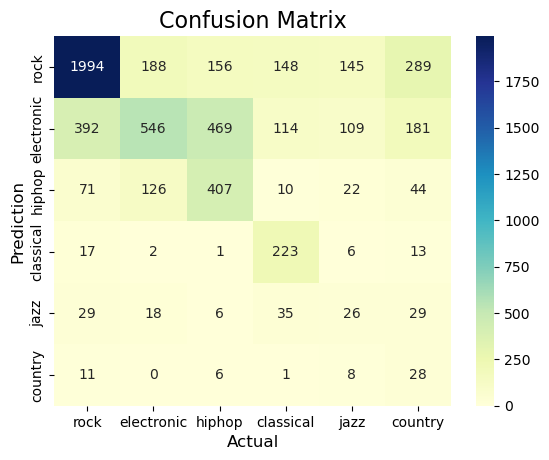

In [139]:
cm_reg = confusion_matrix(y_test, y_pred_smote_lm, labels=in_scope_labels)

sns.heatmap(cm_reg, annot=True,fmt='d', cmap='YlGnBu', xticklabels=in_scope_labels, yticklabels=in_scope_labels)
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

### Gradient Booster

In [67]:
gb_clf = GradientBoostingClassifier()

gb_clf.fit(x_smote,y_smote)

y_pred_gb = gb_clf.predict(X_test)

In [68]:
classification_report_gb = pd.DataFrame(classification_report(y_test, y_pred_gb, output_dict=True)).T

In [69]:
gb_recall = classification_report_gb['recall']

### SVM

In [70]:
svm = svm.SVC() 

svm.fit(x_smote, y_smote)
y_pred_svm = svm.predict(X_test)

In [71]:
classification_report_svm = pd.DataFrame(classification_report(y_test, y_pred_svm, output_dict=True)).T
classification_report_svm

,precision,recall,f1-score,support
blues,0.007156,0.307692,0.013986,13.000000
classical,0.276923,0.774194,0.407932,93.000000
country,0.010499,0.173913,0.019802,23.000000
electronic,0.654008,0.162815,0.260723,952.000000
experimental,0.344828,0.025773,0.047962,388.000000
folk,0.208145,0.536965,0.300000,257.000000
hiphop,0.202350,0.422343,0.273610,367.000000
jazz,0.000000,0.000000,0.000000,70.000000
oldtime / historic,0.600000,0.846154,0.702128,78.000000
pop,0.096154,0.022523,0.036496,222.000000


In [72]:
svm_recall = classification_report_svm['recall']
svm_recall

blues                 0.307692
classical             0.774194
country               0.173913
electronic            0.162815
experimental          0.025773
folk                  0.536965
hiphop                0.422343
jazz                  0.000000
oldtime / historic    0.846154
pop                   0.022523
rock                  0.029218
soulrnb               0.315789
accuracy              0.182331
macro avg             0.301448
weighted avg          0.182331
Name: recall, dtype: float64

### NB

In [73]:
X_train_NB = copy.deepcopy(X_train)
X_train_NB['mfccs_min_abs'] = abs(X_train_NB['mfccs_min'])
X_train_NB['mfccs_mean_abs'] = abs(X_train_NB['mfccs_mean'])
X_train_NB['tonnetz_abs'] = abs(X_train_NB['tonnetz'])
X_train_NB['spectral_centroids_delta_mean_abs'] = abs(X_train_NB['spectral_centroids_delta_mean'])
X_train_NB['spectral_centroids_accelerate_mean_abs'] = abs(X_train_NB['spectral_centroids_accelerate_mean'])

X_train_abs = X_train_NB[['spectral_centroids_mean',
             'spectral_centroids_delta_mean_abs',
             'spectral_centroids_accelerate_mean_abs',
             'spectral_bandwidth_mean',
             'spectral_rolloff_mean',
             'zero_crossing_rate_mean',
             'rms_mean', 
             'chroma_stft_mean',
             'mfccs_mean_abs',
            'tempo',
            'onset',
            'contrast',
            'tonnetz_abs',
            'mfccs_min_abs',
            'mfccs_max']]

X_test_NB = copy.deepcopy(X_test)
X_test_NB['mfccs_min_abs'] = abs(X_test_NB['mfccs_min'])
X_test_NB['mfccs_mean_abs'] = abs(X_test_NB['mfccs_mean'])
X_test_NB['tonnetz_abs'] = abs(X_test_NB['tonnetz'])
X_test_NB['spectral_centroids_delta_mean_abs'] = abs(X_test_NB['spectral_centroids_delta_mean'])
X_test_NB['spectral_centroids_accelerate_mean_abs'] = abs(X_test_NB['spectral_centroids_accelerate_mean'])

X_test_abs = X_test_NB[['spectral_centroids_mean',
             'spectral_centroids_delta_mean_abs',
             'spectral_centroids_accelerate_mean_abs',
             'spectral_bandwidth_mean',
             'spectral_rolloff_mean',
             'zero_crossing_rate_mean',
             'rms_mean', 
             'chroma_stft_mean',
             'mfccs_mean_abs',
            'tempo',
            'onset',
            'contrast',
            'tonnetz_abs',
            'mfccs_min_abs',
            'mfccs_max']]

In [74]:
model = MultinomialNB()
model.fit(X_train_abs, (y_train))
y_pred = model.predict(X_test_abs)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
report = classification_report(y_test, y_pred)
print(report)

0.19446796500141122
                    precision    recall  f1-score   support

             blues       0.00      0.00      0.00        13
         classical       0.15      0.76      0.25        93
           country       0.02      0.04      0.02        23
        electronic       0.40      0.28      0.33       952
      experimental       0.05      0.02      0.03       388
              folk       0.19      0.33      0.24       257
            hiphop       0.30      0.07      0.11       367
              jazz       0.01      0.03      0.01        70
oldtime / historic       0.41      0.60      0.49        78
               pop       0.08      0.08      0.08       222
              rock       0.55      0.15      0.24      1061
           soulrnb       0.01      0.32      0.02        19

          accuracy                           0.19      3543
         macro avg       0.18      0.22      0.15      3543
      weighted avg       0.34      0.19      0.22      3543



In [75]:
classification_report_nb = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

In [76]:
nb_recall = classification_report_nb['recall']
nb_recall

blues                 0.000000
classical             0.763441
country               0.043478
electronic            0.277311
experimental          0.020619
folk                  0.326848
hiphop                0.070845
jazz                  0.028571
oldtime / historic    0.602564
pop                   0.081081
rock                  0.152686
soulrnb               0.315789
accuracy              0.194468
macro avg             0.223603
weighted avg          0.194468
Name: recall, dtype: float64

## Summary Recall Chart 

In [77]:
summary_recall = pd.concat([rf_recall, dt_recall, gb_recall, svm_recall, nb_recall, reg_recall], axis=1)
model_names = ['Random Forest', 'Decision Tree', 'Gradient Booster', 'SVM', 'Multinomial NaiveBayes', 
                   'Logistic Regression']

summary_recall.columns = model_names

summary_recall = summary_recall.T
summary_recall.reset_index(inplace=True)
summary_recall

,index,blues,classical,country,electronic,experimental,folk,hiphop,jazz,oldtime / historic,pop,rock,soulrnb,accuracy,macro avg,weighted avg
0,Random Forest,0.076923,0.806452,0.130435,0.546218,0.443299,0.595331,0.596730,0.214286,0.948718,0.162162,0.667295,0.052632,0.558002,0.436707,0.558002
1,Decision Tree,0.000000,0.602151,0.173913,0.411765,0.283505,0.342412,0.403270,0.200000,0.871795,0.171171,0.491046,0.105263,0.406717,0.338024,0.406717
2,Gradient Booster,0.307692,0.817204,0.391304,0.467437,0.404639,0.517510,0.580381,0.242857,0.961538,0.175676,0.623940,0.315789,0.518205,0.483831,0.518205
3,SVM,0.307692,0.774194,0.173913,0.162815,0.025773,0.536965,0.422343,0.000000,0.846154,0.022523,0.029218,0.315789,0.182331,0.301448,0.182331
4,Multinomial NaiveBayes,0.000000,0.763441,0.043478,0.277311,0.020619,0.326848,0.070845,0.028571,0.602564,0.081081,0.152686,0.315789,0.194468,0.223603,0.194468
5,Logistic Regression,0.307692,0.817204,0.217391,0.180672,0.128866,0.486381,0.534060,0.114286,0.961538,0.031532,0.444863,0.105263,0.336438,0.360812,0.336438


In [78]:
alt.Chart(summary_recall).mark_bar().encode(
    x= alt.X('amount:Q', title=None),
    y= alt.Y ('type:N', title=None),
    color= alt.Color('amount:Q', legend=None),
    column=alt.Column('index', title=None)
).transform_fold(
    as_=['type', 'amount'],
    fold= genres
).properties(width=100, title='Recall by Model')

alt.Chart(...)

## Reduced features/ smote for class imbalance 

In [34]:
#take out two features that do not have much variation based on genre & have the lowest feature importance 
# 'spectral_centroids_delta_mean',
# 'spectral_centroids_accelerate_mean',

#take out highly correlated features:
#spectral_rolloff
#spectral bandwidth 

x_reduced_train = train_df[['spectral_centroids_mean',
           #  'spectral_centroids_delta_mean',
           #  'spectral_centroids_accelerate_mean',
            # 'spectral_bandwidth_mean',
            # 'spectral_rolloff_mean',
             'zero_crossing_rate_mean',
             'rms_mean', 
             'chroma_stft_mean',
             'mfccs_mean',
           # 'tempo',
            'onset',
            'contrast',
            'tonnetz',
            'mfccs_min',
            'mfccs_max']]

x_reduced_test = X_test[['spectral_centroids_mean',
          #   'spectral_centroids_delta_mean',
           #  'spectral_centroids_accelerate_mean',
           #  'spectral_bandwidth_mean',
           #  'spectral_rolloff_mean',
             'zero_crossing_rate_mean',
             'rms_mean', 
             'chroma_stft_mean',
             'mfccs_mean',
          #  'tempo',
            'onset',
            'contrast',
            'tonnetz',
            'mfccs_min',
            'mfccs_max']]

x_smote_reduced, y_smote_reduced = smote.fit_resample(x_reduced_train, y_train)


In [35]:
RandomForest = RandomForestClassifier(random_state=42)
RandomForest.fit(x_smote_reduced, y_smote_reduced)

y_pred_smote_sm = RandomForest.predict(x_reduced_test)

In [36]:
print(classification_report(y_test, y_pred_smote_sm))

                    precision    recall  f1-score   support

             blues       0.00      0.00      0.00        13
         classical       0.47      0.76      0.58        93
           country       0.16      0.26      0.20        23
        electronic       0.66      0.52      0.58       952
      experimental       0.36      0.43      0.39       388
              folk       0.44      0.54      0.49       257
            hiphop       0.47      0.53      0.49       367
              jazz       0.10      0.17      0.13        70
oldtime / historic       0.90      0.96      0.93        78
               pop       0.14      0.16      0.15       222
              rock       0.76      0.66      0.71      1061
           soulrnb       0.15      0.21      0.17        19

          accuracy                           0.54      3543
         macro avg       0.39      0.43      0.40      3543
      weighted avg       0.57      0.54      0.55      3543



## Try to tune parameters for Random Forest

In [37]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [38]:
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_test, y_test)

rf_random.best_params_


Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_depth': 70,
 'bootstrap': False}

In [39]:
{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 20,
 'bootstrap': True}

{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 20,
 'bootstrap': True}

In [40]:
RandomForest_2 = RandomForestClassifier(random_state=42,
                                     n_estimators=  1600,
                                     min_samples_split = 2,
                                     min_samples_leaf = 1,
                                     max_depth = 50,
                                     bootstrap = True)

RandomForest_2.fit(x_smote, y_smote)

y_pred_smote = RandomForest_2.predict(X_test)

In [41]:
print(classification_report(y_test, y_pred_smote))

                    precision    recall  f1-score   support

             blues       0.11      0.08      0.09        13
         classical       0.50      0.81      0.62        93
           country       0.12      0.13      0.12        23
        electronic       0.69      0.55      0.61       952
      experimental       0.38      0.44      0.41       388
              folk       0.45      0.60      0.51       257
            hiphop       0.52      0.61      0.56       367
              jazz       0.19      0.24      0.22        70
oldtime / historic       0.93      0.95      0.94        78
               pop       0.16      0.15      0.16       222
              rock       0.75      0.69      0.72      1061
           soulrnb       0.08      0.05      0.06        19

          accuracy                           0.57      3543
         macro avg       0.41      0.44      0.42      3543
      weighted avg       0.59      0.57      0.57      3543



In [42]:
round(accuracy_score(y_test, y_pred_smote),2)

0.57

In [79]:
feature_importances = RandomForest.feature_importances_
feature_names = x_smote.columns


In [80]:
feature_imp_df = pd.DataFrame(feature_importances).set_index(feature_names)
feature_imp_df.reset_index(inplace=True)
feature_imp_df.columns = ['Features','Importance']
feature_imp_df = feature_imp_df.sort_values(by=['Importance'], ascending=False)
feature_imp_df['count cumsum'] = feature_imp_df['Importance'].cumsum()
feature_imp_df['cum_%'] = feature_imp_df['count cumsum']/(feature_imp_df['Importance'].sum())

feature_imp_df

,Features,Importance,count cumsum,cum_%
8,mfccs_mean,0.099604,0.099604,0.099604
10,onset,0.097500,0.197105,0.197105
4,spectral_rolloff_mean,0.075313,0.272417,0.272417
7,chroma_stft_mean,0.074183,0.346601,0.346601
5,zero_crossing_rate_mean,0.073696,0.420297,0.420297
3,spectral_bandwidth_mean,0.073660,0.493956,0.493956
6,rms_mean,0.070782,0.564739,0.564739
11,contrast,0.069505,0.634244,0.634244
0,spectral_centroids_mean,0.064037,0.698281,0.698281
13,mfccs_min,0.062785,0.761067,0.761067


In [131]:
alt.Chart(feature_imp_df).mark_bar().encode(x=alt.X('Features:N', title=None, sort='-y'), 
                                            y=alt.Y('Importance:Q', title=None),
                                            color=alt.Color('Importance:Q', legend=None)
                                           ).properties(title='Feature Importance', width=400)


base = alt.Chart(feature_imp_df).encode(x = alt.X('Features:N', title=None, sort='-y'))

bar_chart = base.mark_bar(color='#ADD8E6').encode(
    y = alt.Y('Importance:Q', title=None)).properties(width=600)

line = base.mark_line(strokeWidth= 3,color = '#cb4154').encode(
    y = alt.Y('cum_%',
             title=None,
             axis=alt.Axis(format=".0%")),
    text = alt.Text('Importance:Q'))

text = base.mark_text( strokeWidth= 3, color = '#cb4154',
                      align='left',
                      baseline='middle', 
                      dx=-10, 
                      dy = -10
        ).encode(y=alt.Y('cum_%:Q', axis=None),
        text=alt.Text('cum_%:Q', format="0.0%"))

(bar_chart + line + text).resolve_scale(
    y = 'independent'
).properties(title='Feature Importance - Random Forest')

alt.LayerChart(...)

In [126]:
# genres= ['rock', 'electronic', 'soulrnb', 'hiphop', 'classical', 'folk',
#        'pop', 'country', 'oldtime / historic', 'experimental', 'jazz',
#        'blues']


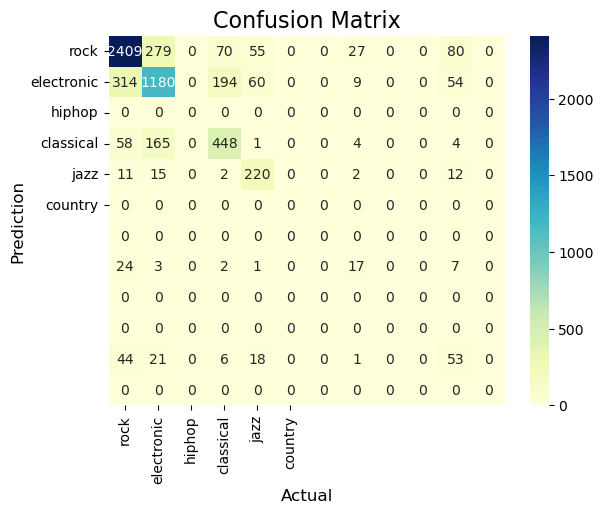

In [129]:
cm = confusion_matrix(y_test, y_pred_smote, labels=in_scope_labels)

sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=in_scope_labels, yticklabels=in_scope_labels)
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()